In [1]:
# tools
import pandas as pd
# plot
import seaborn as sns
import matplotlib.pyplot as plt
# functions
from pathlib import Path
from sklearn.metrics import r2_score

In [2]:
dataset  = Path('../data/raw/installs.csv')
installs = (pd.read_csv(dataset, parse_dates=['created'])
              .assign(created = lambda df: (df.created.dt.floor('h')
                                                      .dt.tz_localize('UTC')
                                                      .dt.tz_convert('America/Montevideo')),
                      weekend = lambda df: df.created.dt.weekday.map(lambda wd: 1 if wd in [5,6] else 0)))

In [3]:
installs.columns

Index(['created', 'application_id', 'ref_type', 'ref_hash', 'click_hash',
       'attributed', 'implicit', 'device_countrycode', 'device_brand',
       'device_model', 'session_user_agent', 'user_agent', 'event_uuid',
       'kind', 'wifi', 'trans_id', 'ip_address', 'device_language', 'weekend'],
      dtype='object')

In [6]:
users_features = ['ref_hash', 'ref_type', 'device_model', 'session_user_agent', 'device_language']
users = (installs.groupby(users_features)
                 .size()
                 .to_frame('instalaciones')
                 .reset_index()
                 .assign(outcome = lambda df: df.instalaciones.map(lambda x: 1 if x > 1 else 0)))

In [7]:
users.head()

,ref_hash,ref_type,device_model,session_user_agent,device_language,instalaciones,outcome
0,4958526679100225,1891515180541284343,7.787531e+18,http-kit/2.0,9.028383e+18,1,0
1,5610335643679608,1891515180541284343,6.882415e+18,adjust.com,3.301378e+18,1,0
2,12589600065022004,1494519392962156891,2.928262e+18,adjust.com,3.301378e+18,1,0
3,13755514797422075,1891515180541284343,2.616228e+18,adjust.com,3.301378e+18,1,0
4,14817751128061288,1891515180541284343,6.882415e+18,adjust.com,3.301378e+18,1,0


In [9]:
users.shape

(2975, 7)

In [8]:
users.outcome.sum()

360

In [10]:
360 / 2975

0.12100840336134454

In [12]:
users = users.drop(columns=['ref_hash', 'instalaciones'])

In [18]:
users.columns

Index(['ref_type', 'device_model', 'session_user_agent', 'device_language',
       'outcome'],
      dtype='object')

In [19]:
fordummies = ['ref_type', 'device_model', 'session_user_agent', 'device_language']
users[fordummies] = users[fordummies].astype(str)

In [22]:
usersDummify = pd.get_dummies(users, prefix=['rf', 'dm', 'sua', 'dl'])

In [78]:
usersDummify.shape

(2975, 457)

In [64]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC

In [69]:
pca = PCA(n_components=30)

In [70]:
userspca = pca.fit_transform(usersDummify.iloc[:, 1:])

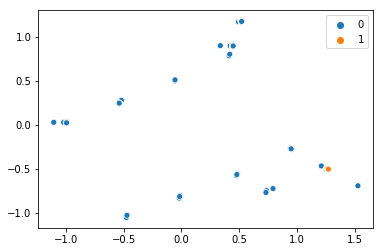

In [71]:
sns.scatterplot(userspca[:, 0], userspca[:, 1], hue=usersDummify.outcome.values)

In [72]:
tsne = TSNE(n_components=2)

In [73]:
userstsne = tsne.fit_transform(userspca)

In [74]:
usersclusters = pd.DataFrame({
    'X': userstsne[:, 0],
    'Y': userstsne[:, 1],
    'outcome': usersDummify.outcome
})

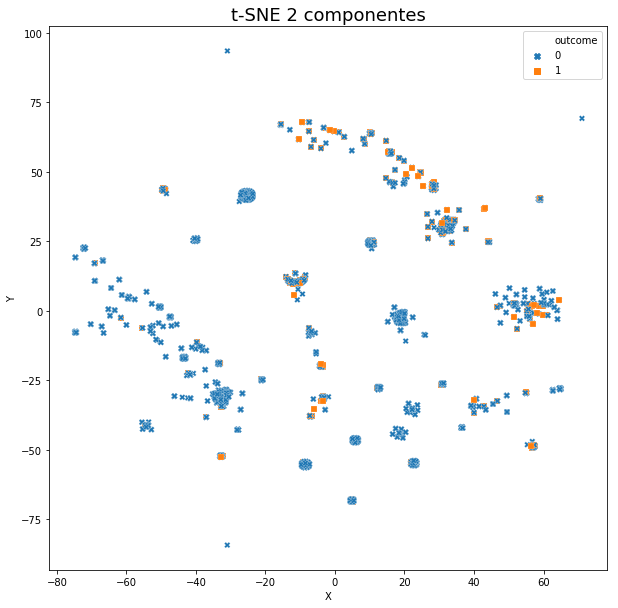

In [115]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.scatterplot('X', 'Y',
                hue='outcome', style='outcome', markers=['X','s'],
                linewidth=0.2, data=usersclusters, ax=ax)

ax.set_title('t-SNE 2 componentes', size=18)
plt.savefig('../assets/insalls_tsne.png', bbox_inches='tight')